>**day.csv have the following fields:**
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 

import statsmodels.api as sm

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score

### Loading and Basic Data Understanding

In [2]:
boombikes_df = pd.read_csv('day.csv')

In [3]:
print(f'Given dataset contains {boombikes_df.shape[0]} rows and {boombikes_df.shape[1]} columns')

Given dataset contains 730 rows and 16 columns


In [4]:
boombikes_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
boombikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


> **As we can see there is no null data in the dataset**

In [6]:
len(boombikes_df[boombikes_df.duplicated()])

0

> **No Duplicate values found**

### Feature Understanding

> **instant**: record index *This column acts just af a serial number and is thus redundant. It will be dropped in next step*.
>
> **dteday**: date *Since purpose of this assignment is aimed at linear regression, and we have been given the day of the week, month, year, holiday data in seperate columns, we will drop this column in next step too*
>
> **season**: season (1:spring, 2:summer, 3:fall, 4:winter) *This feature will be converted to season names so that proper dummies can be created*
>
> **yr**: year (0: 2018, 1:2019) *This column signifies the year in boolean form as indicated.*
>
> **mnth**: month (1 to 12) *This feature will be converted to month names so that proper dummies can be created*
>
> **holiday**: weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule) *This is a binary variable*
>
> **weekday**: day of the week *This feature will be converted to day names so that proper dummies can be created*
>
> **workingday**: if day is neither weekend nor holiday is 1, otherwise is 0. *This variable is an extract of holiday and weekday.*
>
> **weathersit**: Numeric values in this variable will be converted to below mentioned text entries. Post conversion, patterns will be visualized and dummy variables will be created before the model development
>
  > 1: Clear, Few clouds, Partly cloudy, Partly cloudy This will be converted to *Clear to Partly Cloudy*
  >
  > 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist This will be converted to *misty and cloudy*
  >
  > 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds This will be converted to *light rain and light snow*
  >
  > 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog This will be converted to *heavy rain and heavy snow*
>
> **temp**: temperature in Celsius
>
> **atemp**: feeling temperature in Celsius
>
> **hum**: humidity
>
> **windspeed**: wind speed
>
> **casual**: count of casual users Unregistered customers
>
> **registered**: count of registered users
>
> **cnt**: count of total rental bikes including both casual and registered *This is the Target Variable. Since this column is sum of casual and registered, ideally we should drop both the variables. However, we will decide on dropping them at a later stage post visualization.*

#### Dropping features based on above shared logic

In [7]:
boombikes_df.drop(['instant','dteday'], axis=1, inplace=True)

In [8]:
boombikes_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [9]:
boombikes_df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


**Observations:**
>**season**: Season column has 4 values depicting each of the 4 seasons. No deviation found.
>
>**yr***: Data comprises of exactly 2 years
>
>**mnth**: Number of months is exactly 12 hence no abnormalities noticed.
>
>**holiday**: Max is 1 and Min is 0. No deviation in this bollean column
>
>**weekday**: Weekdays are depicted as exactly 7 (0 to 6) corresponding to each day name. On checking data, it was noticed that the numeric values start from 0 on Sunday.
>
>**weathersit**: As per data dictionary, we are supposed to have 4 weather situations whereas the data does not contain 4th weather. The values corerspond to weather situation 1 OR 2 OR 3 only.
>
>**temp**: Variance of temperature is between 2.4 and 35.3 with median value of 20.5. This is indicative of tropical climate in the region as per Wikipedia Article that places mean temperature of tropical regions at around 18+ degree celsius: https://en.wikipedia.org/wiki/Tropical climate This could, to a certain extent, possibly explain the absence of fourth season.
>
>**hum**: Humidity levels Q1 and Q3 are 50% + showing a relatively humid weather.
>
>**windpeed**: Windspeed doesnt show a heavy variance. Relatively calmer winds.
>
>**casual**: Relatively high variance as compared to 'registered'.
>
>**registered**: With given numbers, it seems to be more in line with the trend on target variable (cnt).


### Transforming season, weathersit, mnth and weekday columns based on above logic

In [10]:
boombikes_df['weathersit']  = boombikes_df['weathersit'].map({1:'Clear to Partly Cloudy', 2:'Misty and Cloudy', 3:'Light Rain or Light Snow', 4: 'Heavy Rain or Heavy Snow'})

In [11]:
boombikes_df.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,Misty and Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,Misty and Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801


In [12]:
boombikes_df['season']= boombikes_df['season'].map({1:'Spring', 2:'Summer', 3:'Fail', 4:'Winter'})

In [13]:
boombikes_df.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,Spring,0,1,0,6,0,Misty and Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,Spring,0,1,0,0,0,Misty and Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801


In [14]:
boombikes_df['mnth'] = boombikes_df['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6: 'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10: 'Oct', 11 :'Nov', 12 :'Dec'})

In [15]:
boombikes_df.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,Spring,0,Jan,0,6,0,Misty and Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,Spring,0,Jan,0,0,0,Misty and Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801


In [16]:
boombikes_df['weekday'] = boombikes_df['weekday'].map({0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'})

In [17]:
boombikes_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,Spring,0,Jan,0,Sat,0,Misty and Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,Spring,0,Jan,0,Sun,0,Misty and Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,Spring,0,Jan,0,Mon,1,Clear to Partly Cloudy,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,Spring,0,Jan,0,Tue,1,Clear to Partly Cloudy,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,Spring,0,Jan,0,Wed,1,Clear to Partly Cloudy,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### EDA
#### Univariate Analysis

> **Target Variable**

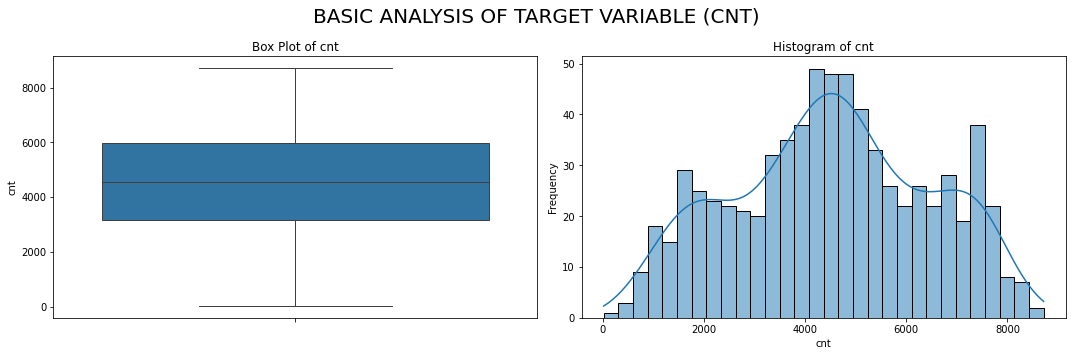

In [18]:
# Create a figure with 1 row and 2 columns of subplots, setting the figure size
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Set the main title for the figure, converting it to uppercase and setting the font size
fig.suptitle('Basic analysis of target variable (cnt)'.upper(), fontsize=20)

# Box plot
# Create a box plot for the 'cnt' column in the first subplot (axes[0])
sns.boxplot(y=boombikes_df['cnt'], ax=axes[0])
# Set the title for the first subplot
axes[0].set_title('Box Plot of cnt')
# Set the y-axis label for the first subplot
axes[0].set_ylabel('cnt')

# Histogram
# Create a histogram for the 'cnt' column in the second subplot (axes[1])
# Enable kernel density estimate (kde) and set the number of bins to 30
sns.histplot(boombikes_df['cnt'], kde=True, bins=30, ax=axes[1])
# Set the title for the second subplot
axes[1].set_title('Histogram of cnt')
# Set the x-axis label for the second subplot
axes[1].set_xlabel('cnt')
# Set the y-axis label for the second subplot
axes[1].set_ylabel('Frequency')

# Adjust the layout to ensure the subplots fit well within the figure
plt.tight_layout()

# Display the plots
plt.show()

**Observations:**
> **Distribution Shape:**

 - The target variable (cnt) shows an almost normal distribution. This indicates that the values of cnt are symmetrically distributed around the mean, forming a bell-shaped curve.
 - There are two distinct plateaus on either side of the distribution. This suggests the presence of two modes or areas where the data values tend to cluster more frequently.


> **Quartile Analysis:**

 - The first quartile (Q1) of the target variable (cnt) lies at around 3000. This means that 25% of the data points are below this value.
 - The third quartile (Q3) is around 6000, indicating that 75% of the data points are below this value.
 - The Interquartile Range (IQR), which is the difference between Q3 and Q1, is approximately 3000. The IQR is a measure of statistical dispersion and indicates the range within which the central 50% of the data points lie.
 - The median of the target variable (cnt) is around 4500. This suggests that half of the data points are below this value, and half are above it.

### Continuous Independent Variables

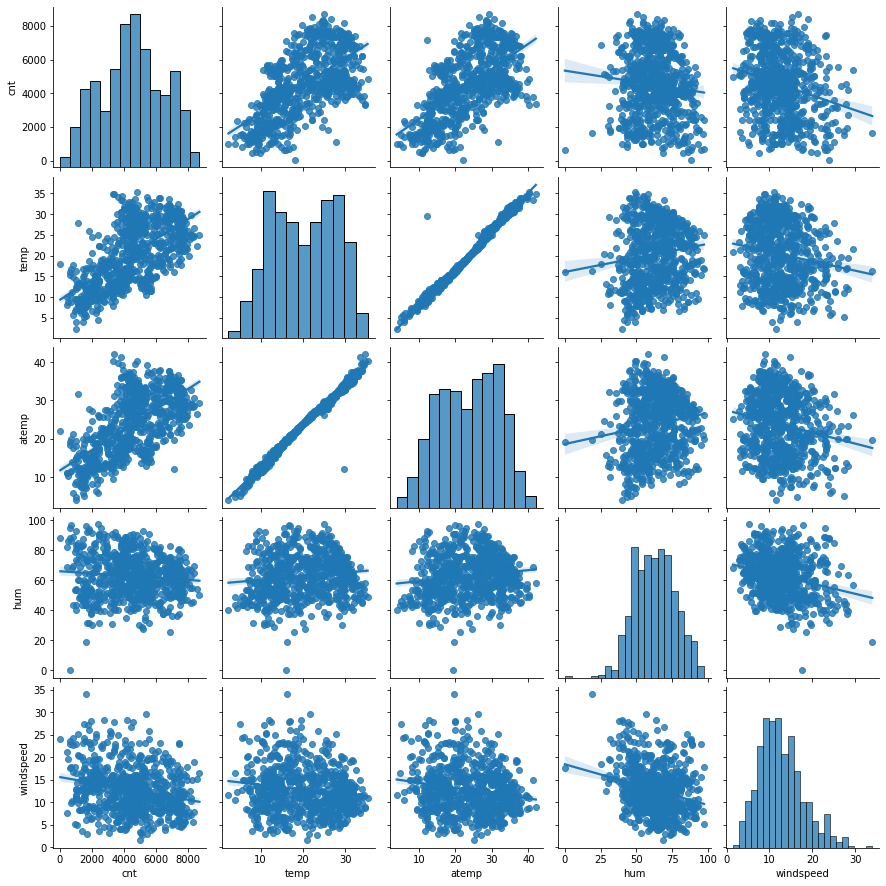

In [19]:
# Lets plot pairplots to have better to see if cnt is linearly  depend upon is independet variables. 
numerical_variabels=['cnt', 'temp', 'atemp', 'hum','windspeed']
sns.pairplot(data=boombikes_df,vars=numerical_variabels, kind="reg")
plt.show()

**Observations:**
  - We can see that we have linealy dependecy between temp, atemp and count.
  - we can also see that temp and atemp is highly correlated.

In [20]:
# Select continuous variables from the DataFrame
# Explanation:
# - 'cont_var': A list to store the names of continuous variables.
# - 'boombikes_df.select_dtypes(exclude='object').columns': Selects all columns in the DataFrame that are not of type 'object' (i.e., numerical columns).
# - 'boombikes_df[i].nunique() > 2': Ensures that the selected numerical columns have more than 2 unique values (i.e., they are continuous rather than binary or categorical).
# - 'i != 'cnt'': Excludes the target variable 'cnt' from the list of continuous variables.

cont_var = [i for i in boombikes_df.select_dtypes(exclude = 'object') if boombikes_df[i].nunique() > 2 and i != 'cnt']

In [21]:
#list of continuous variables
cont_var

['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']

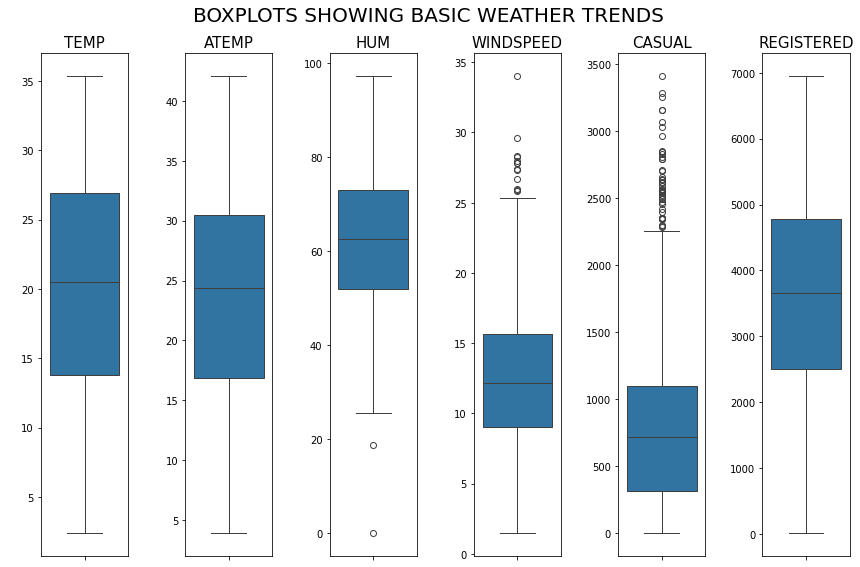

In [22]:
# Create a figure with a number of subplots equal to the number of continuous variables
# Explanation:
# - 'nrows=1': Creates a single row of subplots.
# - 'ncols=len(cont_var)': Creates a column for each continuous variable.
# - 'figsize=(12, 8)': Sets the overall figure size.
fig, ax = plt.subplots(nrows=1, ncols=len(cont_var), figsize=(12, 8))

# Set the main title for the figure, converting it to uppercase and setting the font size
plt.suptitle('boxplots showing basic weather trends'.upper(), fontsize=20)

# Loop through each continuous variable to create a box plot
for i in range(len(cont_var)):
    # Create a box plot for the current continuous variable
    sns.boxplot(y=boombikes_df[cont_var[i]], ax=ax[i])
    
    # Set the title for the current subplot, converting the variable name to uppercase and setting the font size
    ax[i].set_title(f'{cont_var[i].upper()}', fontsize=15)
    
    # Remove the y-axis label for cleaner presentation
    ax[i].set_ylabel(' ')
                    
# Adjust the layout to ensure the subplots fit well within the figure
plt.tight_layout()

# Display the plots
plt.show()


**Observations:**
 - QA and Q3 of Temp is disrtibuted between 14 and 27 with median as 21
 - QA and Q3 of atemp is distributed between 17 and 31 with median 24
 - Humidity, Windspeed and Casual have shown presence of outliers
 - Team and atemp appear to be almost normally distributed

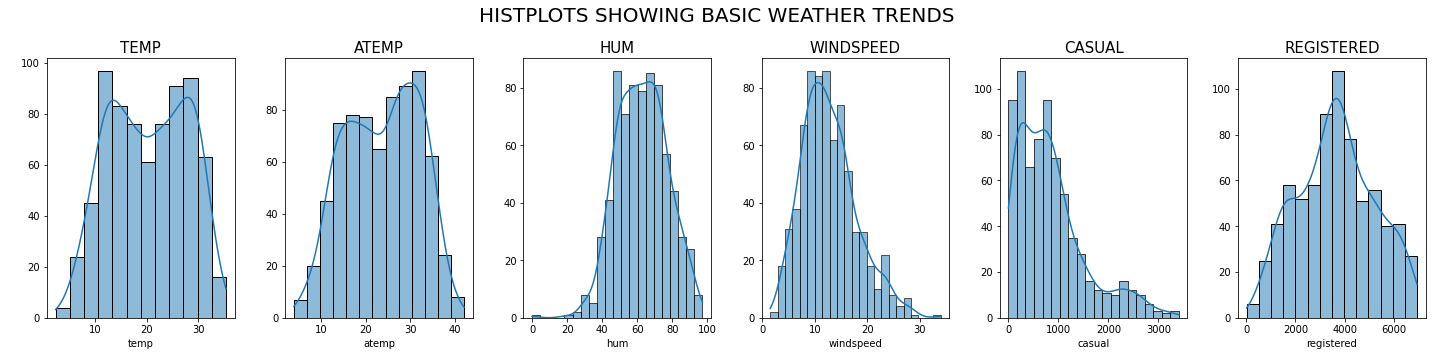

In [23]:
# Create a figure with a number of subplots equal to the number of continuous variables
# Explanation:
# - 'nrows=1': Creates a single row of subplots.
# - 'ncols=len(cont_var_ps)': Creates a column for each continuous variable.
# - 'figsize=(20, 5)': Sets the overall figure size.
fig, ax = plt.subplots(nrows=1, ncols=len(cont_var), figsize=(20, 5))

# Set the main title for the figure, converting it to uppercase and setting the font size
plt.suptitle('histplots showing basic weather trends'.upper(), fontsize=20)

# Loop through each continuous variable to create a histogram
for i in range(len(cont_var)):
    # Create a histogram with a kernel density estimate (kde) for the current continuous variable
    sns.histplot(boombikes_df[cont_var[i]], kde=True, ax=ax[i])
    
    # Set the title for the current subplot, converting the variable name to uppercase and setting the font size
    ax[i].set_title(f'{cont_var[i].upper()}', fontsize=15)
    
    # Remove the y-axis label for cleaner presentation
    ax[i].set_ylabel(' ')
                    
# Adjust the layout to ensure the subplots fit well within the figure
plt.tight_layout()

# Display the plots
plt.show()


**Observations:**
 - Above histplot prove our earlier intuitive understanding of variables as incorrect - Temp and atemp have shown double peaks.
 - Humidity and Windspeed are left and right skewed respectively.
 - Casual shows high right skew.
 - Registered shows similar trend as target variable but plateaus on either side are relatively smoother.

### Categorical Independent Variables

In [24]:
# Select categorical variables from the DataFrame
# Explanation:
# - 'cat_var': A list to store the names of categorical variables.
# - 'boombikes_df.select_dtypes(include='object').columns': Selects columns in the DataFrame that are of type 'object' (i.e., categorical columns).
# - 'boombikes_df[i].nunique() == 2': Checks if the number of unique values in each column is equal to 2, indicating binary categorical variables.
cat_var = [i for i in boombikes_df.select_dtypes(include='object').columns]
cat_var.extend([i for i in boombikes_df.columns if boombikes_df[i].nunique() == 2])


In [25]:
#list of categorical variables
cat_var

['season', 'mnth', 'weekday', 'weathersit', 'yr', 'holiday', 'workingday']

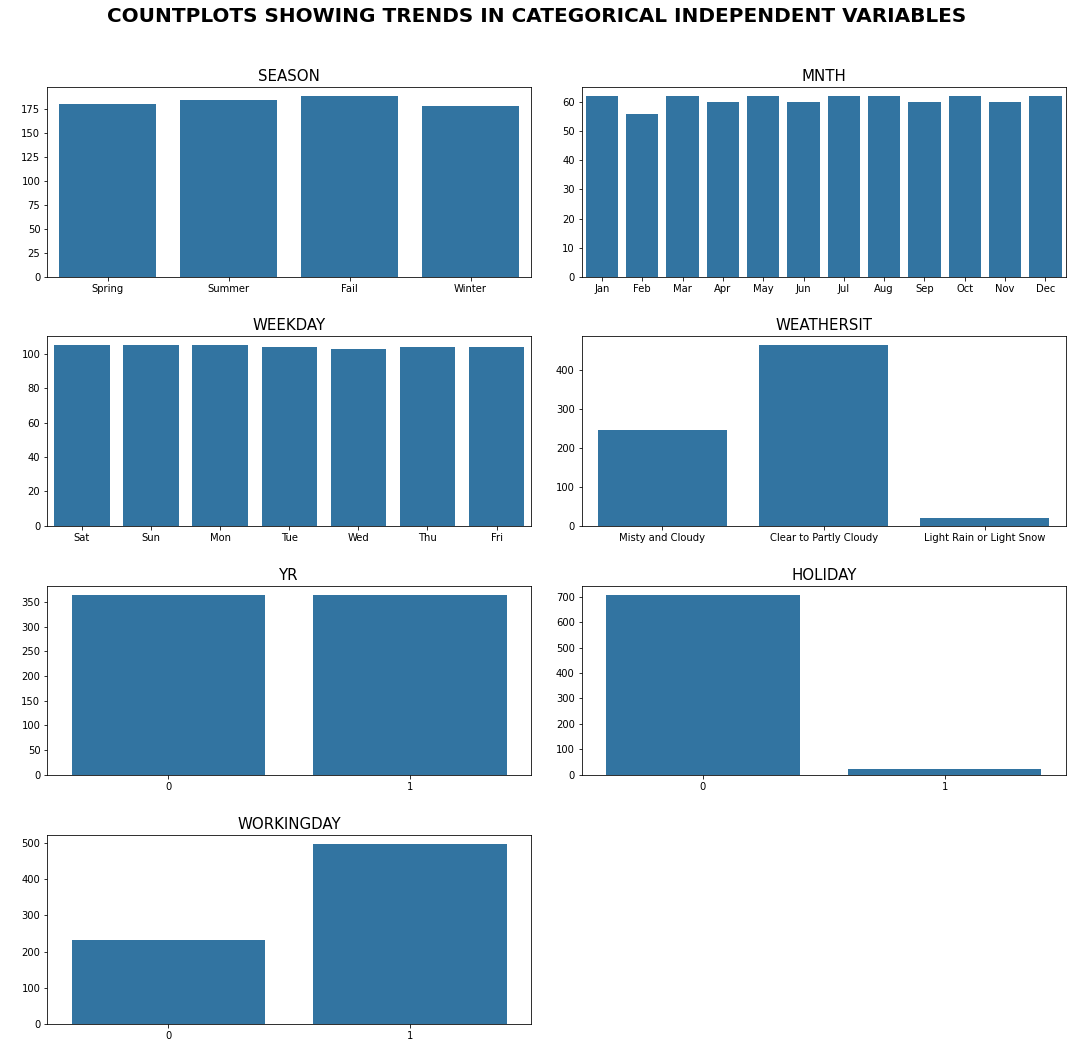

In [26]:
# Calculate the number of rows and columns for the layout
# Explanation:
# - 'num_rows': Number of rows is calculated based on the length of 'cat_var'.
#   - If the length of 'cat_var' is odd, add one additional row to accommodate all categories evenly.
#   - If the length of 'cat_var' is even, divide by 2 to evenly distribute categories across rows.
# - 'num_cols': Fixed to 2 columns for a vertical layout.
num_rows = (len(cat_var)//2) + 1 if len(cat_var) % 2 == 1 else len(cat_var) // 2
num_cols = 2

# Create subplots with the calculated layout and figure size
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))

# Set the main title for the figure, emphasizing it with uppercase and bold font
plt.suptitle('COUNTPLOTS SHOWING TRENDS IN CATEGORICAL INDEPENDENT VARIABLES', fontsize=20, fontweight='bold')

# Initialize counter for iterating through 'cat_var'
k = 0

# Iterate through each subplot
for i in range(num_rows):
    for j in range(num_cols):
        # Check if all categories have been plotted
        if k < len(cat_var):
            # Create a count plot for the current categorical variable
            sns.countplot(x=boombikes_df[cat_var[k]], ax=ax[i, j])
            
            # Set the title for the current subplot, converting the variable name to uppercase and setting the font size
            ax[i, j].set_title(f'{cat_var[k].upper()}', fontsize=15)
            
            # Remove the y-axis label for cleaner presentation
            ax[i, j].set_ylabel(' ')
            
            # Remove the x-axis label for cleaner presentation
            ax[i, j].set_xlabel(' ')
            
            # Increment the counter to move to the next categorical variable
            k += 1
        else:
            # Remove any unused axes if the number of categories is not evenly divisible by the layout
            fig.delaxes(ax[i, j])

# Adjust the layout to prevent overlap with the super title
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plots
plt.show()


**Observations:**
 - Fall is found to be the longest season, followed by summer, followed by Spring. Shortest season is winter.
 - Weathersit shows just 3 types of weathers. There is not even a single day on which Heavy rain/snow has occured. Weather has been clear OR partly cloudy for most of the days in both years.

### Bivariate Analysis

> **Continuous Independent Variables**
 >- The code generates subplots to visualize the relationship between continuous variables and the target variable (cnt). Here's a summary of the code functionality and its output:

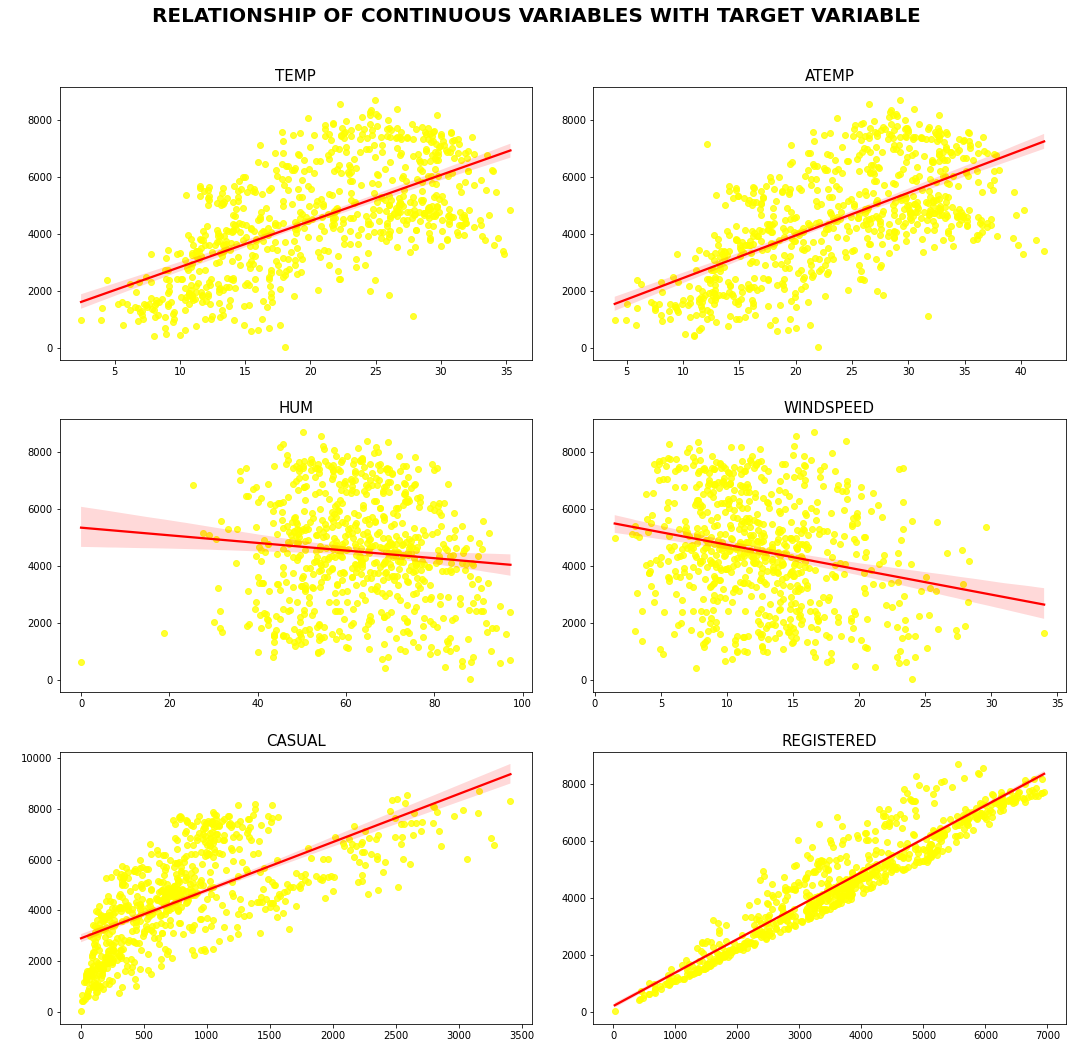

In [27]:
# Calculate the number of rows and columns for the layout
# Explanation:
# - 'num_rows': Number of rows is calculated based on the length of 'cont_var'.
#   - If the length of 'cont_var' is odd, add one additional row to accommodate all variables evenly.
#   - If the length of 'cont_var' is even, divide by 2 to evenly distribute variables across rows.
# - 'num_cols': Fixed to 2 columns for a vertical layout.
num_rows = (len(cont_var)//2) + 1 if len(cont_var) % 2 == 1 else len(cont_var) // 2
num_cols = 2

# Create subplots with the calculated layout and figure size
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))

# Set the main title for the figure, emphasizing it with uppercase and bold font
plt.suptitle('Relationship of continuous variables with target variable'.upper(), fontsize=20, fontweight='bold')

# Initialize counter for iterating through 'cont_var'
k = 0

# Iterate through each subplot
for i in range(num_rows):
    for j in range(num_cols):
        # Check if all variables have been plotted
        if k < len(cont_var):
            # Create a scatter plot with regression line for the current continuous variable against the target variable
            sns.regplot(x=boombikes_df[cont_var[k]], y=boombikes_df['cnt'], ax=ax[i,j],
                        scatter_kws={'color':'yellow'}, line_kws={'color':'red'})
            
            # Set the title for the current subplot, converting the variable name to uppercase and setting the font size
            ax[i, j].set_title(f'{cont_var[k].upper()}', fontsize=15)
            
            # Remove the y-axis label for cleaner presentation
            ax[i, j].set_ylabel(' ')
            
            # Remove the x-axis label for cleaner presentation
            ax[i, j].set_xlabel(' ')
            
            # Increment the counter to move to the next continuous variable
            k += 1

# Adjust the layout to prevent overlap with the super title
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plots
plt.show()


**Observations:**
 - Bike demand shows a similar and directly proportional relationship with temp and atemp
 - Bike demand shows inverse proportionality with Humidity and Windspeed.
 -  Bike demand is directly proportional to Casual and Registered numbers.
 - Bike demand is very well explained by the registered users.

> **Barcharts for categorical variables to see demands**
  >
  >The provided code defines a function named **plot_bar_graphs()** to create bar plots related to categorical columns in a dataset

In [28]:
# function to create barplot related to categorical columns

def plot_bar_graphs(column):
    plt.figure(figsize=(12, 6))
    
    # Define custom colors for the years
    palette = {0: 'skyblue', 1: 'orange'}  # 0 for 2018 and 1 for 2019
    
    # Plot 1: Bar plot of the specified column vs 'cnt'
    plt.subplot(1, 2, 1)
    sns.barplot(x=column, y='cnt', data=boombikes_df, errorbar=None)
    plt.title(f'Bar Plot of {column} vs cnt')
    plt.xlabel(column)
    plt.ylabel('Total Count')
    
    # Plot 2: Bar plot of the specified column vs 'cnt' with 'yr' as hue
    plt.subplot(1, 2, 2)
    sns.barplot(x=column, y='cnt', data=boombikes_df, hue='yr', palette=palette, errorbar=None)
    plt.title(f'Bar Plot of {column} vs cnt (2018 vs 2019)')
    plt.xlabel(column)
    plt.ylabel('Total Count')
    
    # Update legend with custom colors
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = ['2018', '2019']  # Update labels for clarity
    plt.legend(handles=handles, labels=labels, title='Year')
    
    plt.tight_layout()
    plt.show()

In [29]:
#list of categorical variables
cat_var

['season', 'mnth', 'weekday', 'weathersit', 'yr', 'holiday', 'workingday']

> The provided loop iterates through each *categorical variable (cat_var)* in the dataset and generates bar plots to visualize their relationship with the target variable (cnt)

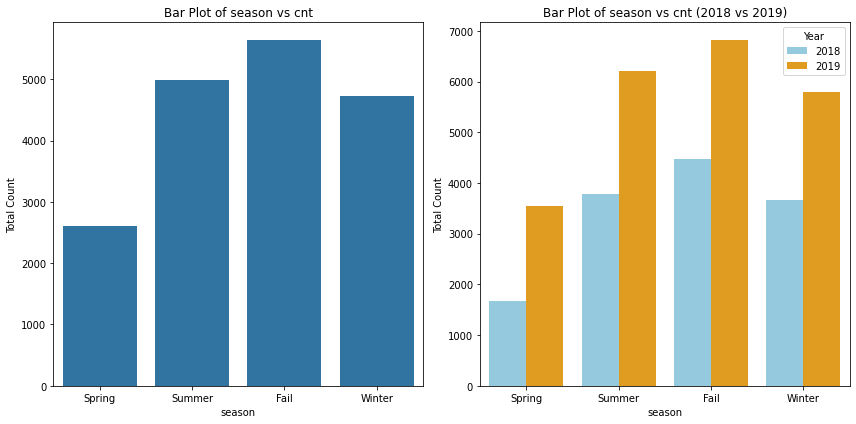

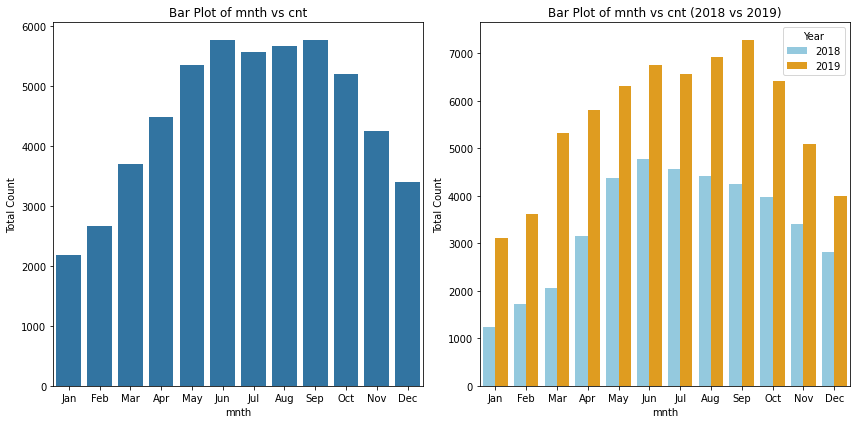

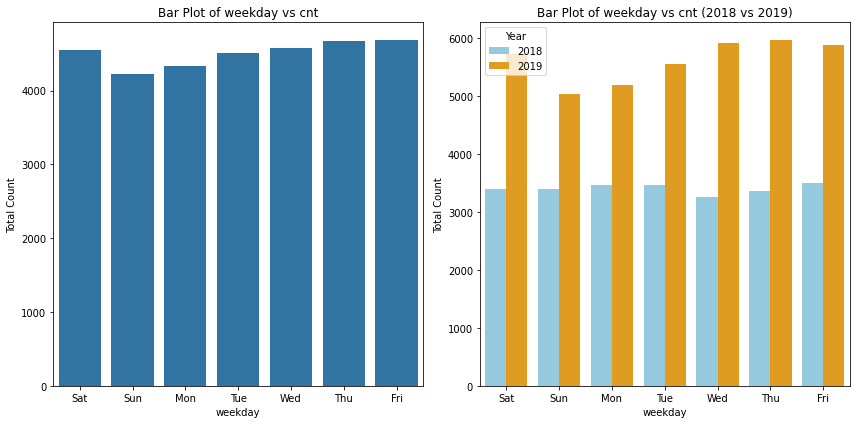

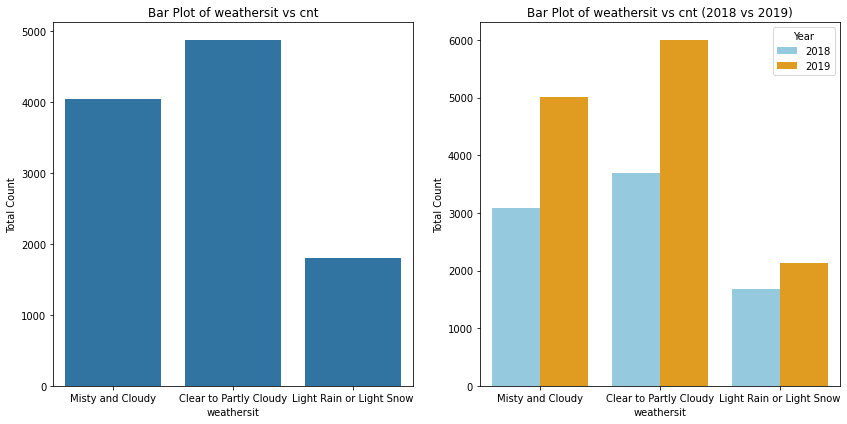

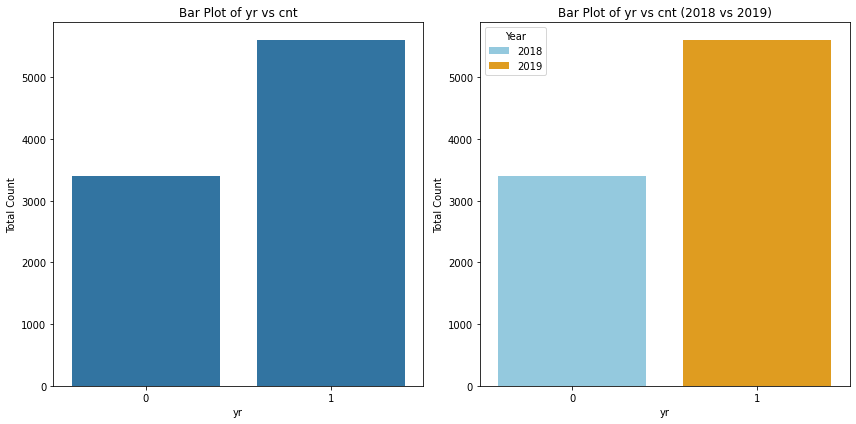

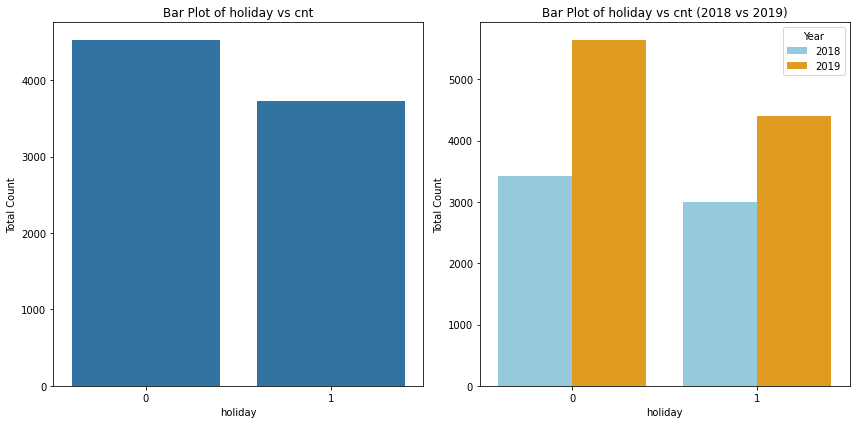

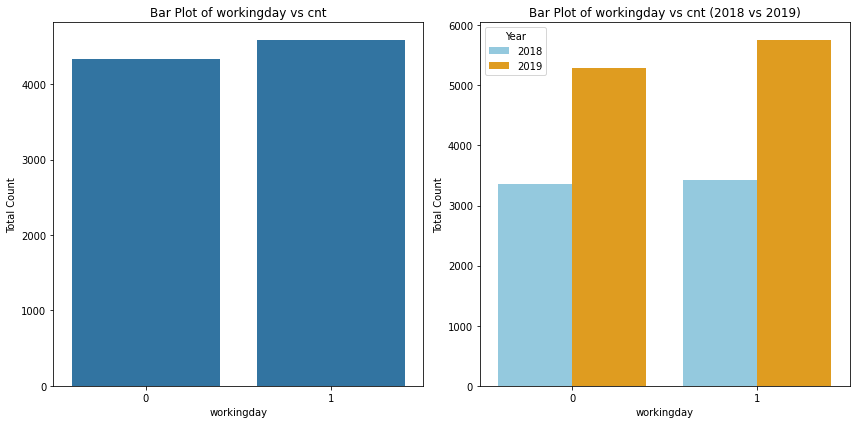

In [30]:
# Iterate through each categorical variable in the dataset
for i in cat_var:
    # Call the plot_bar_graphs function to create bar plots for the current categorical variable
    plot_bar_graphs(i)


**Observations:**
 >**Season:**
  >-Fall  seasons is having high number bike rental.
  >-Bike rental in 2019 has increaded for every seasion compared to 2018.
  >
 >**Mnth**:
  >-May to oct is having more number of bike registration.
  >-Bike registration in 2019 has increased for every month compared to 2018.
  >
 >**weathersit**:
  >-People prefer bike rental when weather situations is good. 
  >-Bike registration in 2019 has increased for every weather situtation 2018.
  >
 >**holiday**:
  >-People dont prefer renting bike holiday.

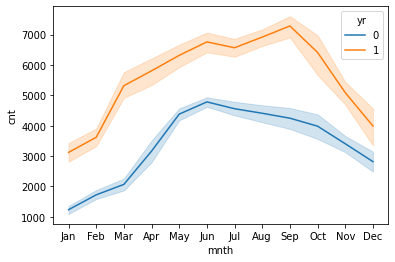

In [31]:
# Line graph will that show the count vs month for year 2018 and 2019.
sns.lineplot(x = "mnth", y = "cnt", data=boombikes_df,hue = "yr")
plt.show()

**Observations:**
 - From Line Graph we can see that target Variable cnt has increased from 2018 to 2019.
 - Demand for bike is high between may to oct for year 2018 and 2019.

>**HeatMap to indentify is there any correlation**

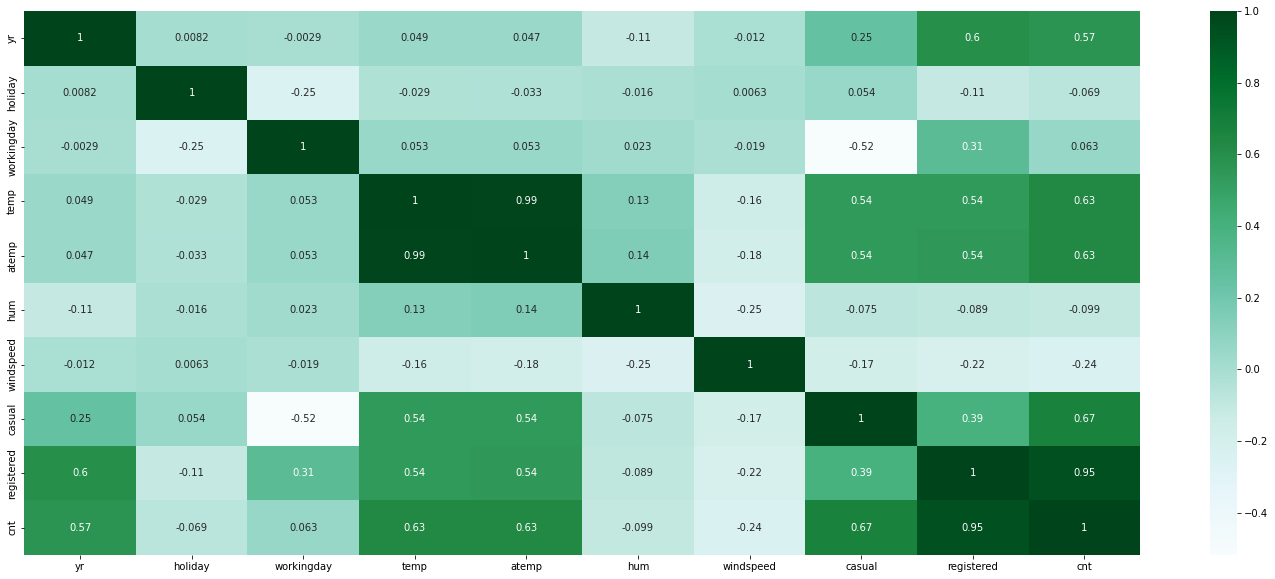

In [32]:
# Select only the numeric columns
numeric_columns = boombikes_df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(25, 10))
sns.heatmap(corr_matrix, cmap='BuGn', annot=True)
plt.show()

 **Observations: from heatmap:** 
>1. Since Count is sum of casual and registered. That we can infer from  heatmap as casual and registered are highly correleted with cnt. 
>2. holiday, hum, and windspeed is negatively correlated. 
>3. Indepedent variable temp and atemp is highly correlated(0.99).This show that there is high possiblity that one may have derived from another,One of the them can be dropped. Will use VIF and p values to drop this.

In [33]:
# Dropping casual and Registed as  they sumed to Cnt.

boombikes_df.drop(['casual','registered'],axis=1,inplace=True)

In [34]:
boombikes_df.shape

(730, 12)

### Data Preparation

In [35]:
boombikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


> The provided code snippet applies a lambda function to each column in the DataFrame (boombikes_df). The lambda function checks the data type of each column and converts columns with data type 'object' to categorical data type.

In [36]:
# Convert object-type columns to categorical data type
# Explanation:
# - The lambda function applies a conversion to categorical data type for each column in the DataFrame.
# - It checks the data type of each column, and if it's 'object' (indicating string values), it converts it to categorical.
# - This conversion optimizes memory usage and improves performance, especially for columns with limited unique values.
# - Categorical data type internally represents each unique value with an integer code, enhancing data management and analysis.
boombikes_df = boombikes_df.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)


In [37]:
boombikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    int64   
 2   mnth        730 non-null    category
 3   holiday     730 non-null    int64   
 4   weekday     730 non-null    category
 5   workingday  730 non-null    int64   
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   hum         730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(4), float64(4), int64(4)
memory usage: 49.7 KB


In [38]:
# Select categorical columns in the DataFrame
categorical_columns = boombikes_df.select_dtypes(include=['category']).columns

In [39]:
# we need to create a dummy variables for four categorical variables. mnth', 'weekday', 'season' & 'weathersit
categorical_columns

Index(['season', 'mnth', 'weekday', 'weathersit'], dtype='object')

In [40]:
# Convert categorical variable 'weathersit' into dummy variables
weathersit_d = pd.get_dummies(boombikes_df['weathersit'], prefix = 'weathersit', drop_first=True).astype('int64')

In [41]:
weathersit_d

,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0
...,...,...
725,0,1
726,0,1
727,0,1
728,0,0


In [42]:
# Convert categorical variable 'weekday' into dummy variables
weekday_d = pd.get_dummies(boombikes_df['weekday'], prefix='weekday', drop_first=True).astype('int64')

In [43]:
# Convert categorical variable 'mnth' into dummy variables
mnth_d = pd.get_dummies(boombikes_df['mnth'], prefix='mnth', drop_first=True).astype('int64')

In [44]:
# Convert categorical variable 'season' into dummy variables
season_d = pd.get_dummies(boombikes_df['season'], prefix='season', drop_first=True).astype('int64')

In [45]:
# Concatenate dummy variables with the original DataFrame
boombikes_df = pd.concat([boombikes_df, season_d, mnth_d, weekday_d, weathersit_d], axis=1)

> The provided code snippet drops the original categorical columns from the DataFrame boombikes_df after concatenating their corresponding dummy variables.

In [46]:
columns_to_drop  = ['season', 'mnth', 'weekday', 'weathersit']
boombikes_df = boombikes_df.drop(columns = columns_to_drop,axis=1)

In [47]:
boombikes_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,1,0,0


In [48]:
boombikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   yr                                   730 non-null    int64  
 1   holiday                              730 non-null    int64  
 2   workingday                           730 non-null    int64  
 3   temp                                 730 non-null    float64
 4   atemp                                730 non-null    float64
 5   hum                                  730 non-null    float64
 6   windspeed                            730 non-null    float64
 7   cnt                                  730 non-null    int64  
 8   season_Spring                        730 non-null    int64  
 9   season_Summer                        730 non-null    int64  
 10  season_Winter                        730 non-null    int64  
 11  mnth_Aug                        

#### Divide the train and test data

In [49]:
np.random.seed(0)
df_train, df_test = train_test_split(boombikes_df, train_size=0.70, test_size=0.30, random_state=100)

In [50]:
print(f'Training set:{df_train.shape}')
print(f'Test set:{df_test.shape}')

Training set:(510, 30)
Test set:(219, 30)


#### Scaling numeric variables

In [51]:
#scaling numeric variables of traning data using MinMaxScalor between 0-1.
num_vars =  ['temp', 'atemp', 'hum', 'windspeed','cnt']
scaler=MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [52]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,...,1,0,0,0,0,0,1,0,0,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,1,0,0,0,0,0,1


In [53]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620,0.243137,0.245098,...,0.086275,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.343137
std,0.500429,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593,0.429398,0.430568,...,0.281045,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Splitting Training Dataset in X and y

In [54]:
# seperating independent and dependent variables
y_train = df_train.pop('cnt')
X_train = df_train

In [55]:
print(f'X_train shape : {X_train.shape}, y_train shape:{y_train.shape}')

X_train shape : (510, 29), y_train shape:(510,)


### Build a Model

#### Model#1 with all the available features

In [56]:
# Building a model with all features using statsmodels :
X_train_lm = sm.add_constant(X_train)
lm1= sm.OLS(y_train, X_train_lm).fit()
lm1.params

const                                  0.245237
yr                                     0.232208
holiday                                0.010689
workingday                             0.096962
temp                                   0.401322
atemp                                  0.050628
hum                                   -0.151812
windspeed                             -0.184388
season_Spring                         -0.048580
season_Summer                          0.038216
season_Winter                          0.105387
mnth_Aug                               0.016076
mnth_Dec                              -0.045572
mnth_Feb                              -0.032176
mnth_Jan                              -0.062565
mnth_Jul                              -0.039277
mnth_Jun                              -0.001704
mnth_Mar                               0.001288
mnth_May                               0.024691
mnth_Nov                              -0.041783
mnth_Oct                               0

In [57]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Wed, 29 May 2024   Prob (F-statistic):          8.42e-181
Time:                        12:47:35   Log-Likelihood:                 528.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     481   BIC:                            -875.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.2452      0.035      6.953      0.000       0.176       0.315
yr                                      0.2322      0.008     28.792      0.000       0.216       0.248
holiday                                 0.0107      0.024      0.443      0.658      -0.037       0.058
workingday                              0.0970      0.012      7.903      0.000       0.073       0.121
temp                                    0.4013      0.142      2.821      0.005       0.122       0.681
atemp                                   0.0506      0.138      0.366      0.714      -0.221       0.322
hum                                    -0.1518      0.039     -3.940      0.000      -0.228      -0.076
windspeed                              -0.1844      0.026     -7.003      0.000      -0.236      -0.133
season_Spring                          -0.0486      0.030     -1.618      0.106      -0.108       0.010
season_Summer                           0.0382      0.026      1.455      0.146      -0.013       0.090
season_Winter                           0.1054      0.028      3.770      0.000       0.050       0.160
mnth_Aug                                0.0161      0.034      0.473      0.637      -0.051       0.083
mnth_Dec                               -0.0456      0.034     -1.356      0.176      -0.112       0.020
mnth_Feb                               -0.0322      0.033     -0.978      0.329      -0.097       0.032
mnth_Jan                               -0.0626      0.034     -1.864      0.063      -0.129       0.003
mnth_Jul                               -0.0393      0.035     -1.116      0.265      -0.108       0.030
mnth_Jun                               -0.0017      0.025     -0.067      0.946      -0.051       0.048
mnth_Mar                                0.0013      0.025      0.052      0.958      -0.047       0.050
mnth_May                                0.0247      0.021      1.169      0.243      -0.017       0.066
mnth_Nov                               -0.0418      0.036     -1.149      0.251      -0.113       0.030
mnth_Oct                                0.0077      0.036      0.215      0.830      -0.063       0.078
mnth_Sep                                0.0818      0.032      2.549      0.011       0.019       0.145
weekday_Mon                            -0.0215      0.015     -1.395      0.164      -0.052       0.009
weekday_Sat                             0.0961      0.014      6.984      0.000       0.069       0.123
weekday_Sun                             0.0415      0.014      2.974      0.003       0.014       0.069
weekday_Thu                            -0.0097      0.016     -0.625      0.532      -0.040       0.021
weekday_Tue                            -0.0193      0.016     -1.24

**Observation**:
> Here, we can see that all adjusted R-Squared is 0.845 is pretty good.Lets us see if we can reduce the independet features
>
> Since the number of predictor variables is around 30. It will not be feasible to manually eliminate the insignificance variable.Will use hybrid (RFE + manual) to elimnate insignifiance variable.

### Recursive Feature Elimination (RFE)

>The provided code snippet fits a linear regression model (lm) to the training data (X_train, y_train) and then applies Recursive Feature Elimination (RFE) to select the top 15 features for the model

In [58]:
# Fit a linear regression model to the training data
lm = LinearRegression()
lm.fit(X_train, y_train)

# Apply Recursive Feature Elimination (RFE) to select the top 15 features
rfe = RFE(estimator=lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)


In [59]:
#observation of result
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 5),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Summer', True, 1),
 ('season_Winter', True, 1),
 ('mnth_Aug', False, 4),
 ('mnth_Dec', False, 11),
 ('mnth_Feb', False, 7),
 ('mnth_Jan', False, 15),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 6),
 ('mnth_Mar', False, 3),
 ('mnth_May', False, 13),
 ('mnth_Nov', False, 10),
 ('mnth_Oct', False, 2),
 ('mnth_Sep', True, 1),
 ('weekday_Mon', False, 12),
 ('weekday_Sat', True, 1),
 ('weekday_Sun', True, 1),
 ('weekday_Thu', False, 9),
 ('weekday_Tue', False, 14),
 ('weekday_Wed', False, 8),
 ('weathersit_Light Rain or Light Snow', True, 1),
 ('weathersit_Misty and Cloudy', True, 1)]

In [60]:
# RFE support Variables
col = X_train.columns[rfe.support_]
print(len(col))
print(col)

15
Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_Spring', 'season_Summer', 'season_Winter', 'mnth_Jul',
       'mnth_Sep', 'weekday_Sat', 'weekday_Sun',
       'weathersit_Light Rain or Light Snow', 'weathersit_Misty and Cloudy'],
      dtype='object')


In [61]:
# RFE not Supported Variables
X_train.columns[~rfe.support_]

Index(['atemp', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jun',
       'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct', 'weekday_Mon',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed'],
      dtype='object')

> The provided code defines a function **calculateVIF(df)** to calculate the Variance Inflation Factor (VIF) for each feature in a DataFrame

In [62]:
# Function to calculate Variance Inflation Factor (VIF) of variables
def calculateVIF(df):
    """
    Calculate the Variance Inflation Factor (VIF) for each feature in a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the features for which VIF is calculated.

    Returns:
    DataFrame: A DataFrame with columns 'Features' and 'VIF' containing the VIF values for each feature.
    """
    # Initialize an empty DataFrame to store VIF values
    vif = pd.DataFrame()

    # Add feature names to the DataFrame
    vif['Features'] = df.columns

    # Calculate VIF for each feature
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    # Round the VIF values to 2 decimal places
    vif['VIF'] = round(vif['VIF'], 2)

    # Sort the DataFrame by VIF values in descending order
    vif = vif.sort_values(by="VIF", ascending=False)

    return vif

In [63]:
# Lets consider only  the RFE supported columns for first model building 
X_train_1 = X_train[col]

>**Model#2**

In [64]:
X_train_lm2 = sm.add_constant(X_train_1)

# Create a first fitted model
lm2 = sm.OLS(y_train, X_train_lm2).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Wed, 29 May 2024   Prob (F-statistic):          1.13e-191
Time:                        12:47:35   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.1989      0.028      7.181      0.000       0.144       0.253
yr                                      0.2297      0.008     28.660      0.000       0.214       0.245
holiday                                -0.0190      0.021     -0.892      0.373      -0.061       0.023
workingday                              0.0837      0.010      8.672      0.000       0.065       0.103
temp                                    0.5278      0.033     15.897      0.000       0.463       0.593
hum                                    -0.1595      0.037     -4.268      0.000      -0.233      -0.086
windspeed                              -0.1806      0.025     -7.110      0.000      -0.231      -0.131
season_Spring                          -0.0554      0.021     -2.694      0.007      -0.096      -0.015
season_Summer                           0.0526      0.015      3.553      0.000       0.024       0.082
season_Winter                           0.1003      0.017      5.890      0.000       0.067       0.134
mnth_Jul                               -0.0549      0.018     -3.035      0.003      -0.090      -0.019
mnth_Sep                                0.0818      0.016      4.956      0.000       0.049       0.114
weekday_Sat                             0.0937      0.012      8.045      0.000       0.071       0.117
weekday_Sun                             0.0405      0.012      3.304      0.001       0.016       0.065
weathersit_Light Rain or Light Snow    -0.2463      0.026     -9.449      0.000      -0.298      -0.195
weathersit_Misty and Cloudy            -0.0578      0.010     -5.559      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       64.879   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.454
Skew:                          -0.661   Prob(JB):                     3.91e-35
Kurtosis:                       5.390   Cond. No.                     1.12e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.2e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [65]:
calculateVIF(X_train_1)

,Features,VIF
2,workingday,50.69
11,weekday_Sat,12.20
12,weekday_Sun,11.79
6,season_Spring,5.02
3,temp,3.62
8,season_Winter,3.49
1,holiday,2.91
7,season_Summer,2.61
4,hum,1.91
14,weathersit_Misty and Cloudy,1.57


>From above VIF table we can see that workingday is having ~51 vif value which is quite high. lets remove this featues.

In [66]:
X_train_2 = X_train_1.drop(["workingday"], axis = 1)
X_train_2.head()

,yr,holiday,temp,hum,windspeed,season_Spring,season_Summer,season_Winter,mnth_Jul,mnth_Sep,weekday_Sat,weekday_Sun,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
653,1,0,0.509887,0.575354,0.300794,0,0,1,0,0,0,0,0,0
576,1,0,0.815169,0.725633,0.264686,0,0,0,1,0,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,1,0,0,0,0,1,0,0,1
728,1,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,1,0,0
482,1,0,0.395666,0.504508,0.188475,0,1,0,0,0,1,0,0,1


>**Model#3**

In [67]:
X_train_lm3 = sm.add_constant(X_train_2)

# Create a first fitted model
lm3 = sm.OLS(y_train, X_train_lm3).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Wed, 29 May 2024   Prob (F-statistic):          1.13e-191
Time:                        12:47:35   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.2826      0.034      8.286      0.000       0.216       0.350
yr                                      0.2297      0.008     28.660      0.000       0.214       0.245
holiday                                -0.1027      0.025     -4.047      0.000      -0.152      -0.053
temp                                    0.5278      0.033     15.897      0.000       0.463       0.593
hum                                    -0.1595      0.037     -4.268      0.000      -0.233      -0.086
windspeed                              -0.1806      0.025     -7.110      0.000      -0.231      -0.131
season_Spring                          -0.0554      0.021     -2.694      0.007      -0.096      -0.015
season_Summer                           0.0526      0.015      3.553      0.000       0.024       0.082
season_Winter                           0.1003      0.017      5.890      0.000       0.067       0.134
mnth_Jul                               -0.0549      0.018     -3.035      0.003      -0.090      -0.019
mnth_Sep                                0.0818      0.016      4.956      0.000       0.049       0.114
weekday_Sat                             0.0100      0.011      0.896      0.371      -0.012       0.032
weekday_Sun                            -0.0432      0.012     -3.744      0.000      -0.066      -0.021
weathersit_Light Rain or Light Snow    -0.2463      0.026     -9.449      0.000      -0.298      -0.195
weathersit_Misty and Cloudy            -0.0578      0.010     -5.559      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       64.879   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.454
Skew:                          -0.661   Prob(JB):                     3.91e-35
Kurtosis:                       5.390   Cond. No.                         19.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
calculateVIF(X_train_2)

,Features,VIF
3,hum,28.28
2,temp,16.06
4,windspeed,4.68
5,season_Spring,4.03
7,season_Winter,3.37
6,season_Summer,2.78
13,weathersit_Misty and Cloudy,2.30
0,yr,2.08
8,mnth_Jul,1.59
9,mnth_Sep,1.39


> From above we can see that *weekday_sat* is having high pValue 0.371  and hum VIP is 28.28.
>
>Lets drop *weekday_sat*

In [69]:
X_train_3 = X_train_2.drop(["weekday_Sat"], axis = 1)
X_train_3.head()

,yr,holiday,temp,hum,windspeed,season_Spring,season_Summer,season_Winter,mnth_Jul,mnth_Sep,weekday_Sun,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
653,1,0,0.509887,0.575354,0.300794,0,0,1,0,0,0,0,0
576,1,0,0.815169,0.725633,0.264686,0,0,0,1,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,1,0,0,0,0,0,0,1
728,1,0,0.245101,0.498067,0.663106,1,0,0,0,0,1,0,0
482,1,0,0.395666,0.504508,0.188475,0,1,0,0,0,0,0,1


>**Model#4**

In [70]:
X_train_lm4 = sm.add_constant(X_train_3)

# Create a first fitted model
lm4 = sm.OLS(y_train, X_train_lm4).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     211.4
Date:                Wed, 29 May 2024   Prob (F-statistic):          1.13e-192
Time:                        12:47:35   Log-Likelihood:                 517.45
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     496   BIC:                            -947.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.2852      0.034      8.395      0.000       0.218       0.352
yr                                      0.2295      0.008     28.652      0.000       0.214       0.245
holiday                                -0.1046      0.025     -4.141      0.000      -0.154      -0.055
temp                                    0.5274      0.033     15.888      0.000       0.462       0.593
hum                                    -0.1607      0.037     -4.305      0.000      -0.234      -0.087
windspeed                              -0.1798      0.025     -7.085      0.000      -0.230      -0.130
season_Spring                          -0.0554      0.021     -2.692      0.007      -0.096      -0.015
season_Summer                           0.0526      0.015      3.549      0.000       0.023       0.082
season_Winter                           0.1006      0.017      5.908      0.000       0.067       0.134
mnth_Jul                               -0.0546      0.018     -3.020      0.003      -0.090      -0.019
mnth_Sep                                0.0819      0.016      4.964      0.000       0.049       0.114
weekday_Sun                            -0.0451      0.011     -3.970      0.000      -0.067      -0.023
weathersit_Light Rain or Light Snow    -0.2460      0.026     -9.438      0.000      -0.297      -0.195
weathersit_Misty and Cloudy            -0.0577      0.010     -5.544      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       61.439   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.341
Skew:                          -0.616   Prob(JB):                     1.85e-34
Kurtosis:                       5.407   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
calculateVIF(X_train_3)

,Features,VIF
3,hum,28.28
2,temp,16.03
4,windspeed,4.65
5,season_Spring,4.01
7,season_Winter,3.35
6,season_Summer,2.78
12,weathersit_Misty and Cloudy,2.30
0,yr,2.08
8,mnth_Jul,1.59
9,mnth_Sep,1.39


> we can see that Adj. R-squared is 0.843 and pvalue is less than 0.05 for every features.
>
>VIF for hum is 28+.so remove the hum.

In [72]:
X_train_4 = X_train_3.drop(["hum"], axis = 1)
X_train_4.head()

,yr,holiday,temp,windspeed,season_Spring,season_Summer,season_Winter,mnth_Jul,mnth_Sep,weekday_Sun,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
653,1,0,0.509887,0.300794,0,0,1,0,0,0,0,0
576,1,0,0.815169,0.264686,0,0,0,1,0,0,0,0
426,1,0,0.442393,0.255342,1,0,0,0,0,0,0,1
728,1,0,0.245101,0.663106,1,0,0,0,0,1,0,0
482,1,0,0.395666,0.188475,0,1,0,0,0,0,0,1


>**Model#5**

In [73]:
X_train_lm5 = sm.add_constant(X_train_4)

# Create a first fitted model
lm5 = sm.OLS(y_train, X_train_lm5).fit()
lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     219.8
Date:                Wed, 29 May 2024   Prob (F-statistic):          6.45e-190
Time:                        12:47:36   Log-Likelihood:                 508.10
No. Observations:                 510   AIC:                            -990.2
Df Residuals:                     497   BIC:                            -935.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.2063      0.029      7.088      0.000       0.149       0.263
yr                                      0.2334      0.008     28.819      0.000       0.217       0.249
holiday                                -0.1057      0.026     -4.114      0.000      -0.156      -0.055
temp                                    0.4912      0.033     15.034      0.000       0.427       0.555
windspeed                              -0.1479      0.025     -5.989      0.000      -0.196      -0.099
season_Spring                          -0.0653      0.021     -3.140      0.002      -0.106      -0.024
season_Summer                           0.0464      0.015      3.092      0.002       0.017       0.076
season_Winter                           0.0861      0.017      5.070      0.000       0.053       0.119
mnth_Jul                               -0.0496      0.018     -2.701      0.007      -0.086      -0.014
mnth_Sep                                0.0759      0.017      4.536      0.000       0.043       0.109
weekday_Sun                            -0.0485      0.012     -4.207      0.000      -0.071      -0.026
weathersit_Light Rain or Light Snow    -0.2904      0.024    -11.928      0.000      -0.338      -0.243
weathersit_Misty and Cloudy            -0.0835      0.009     -9.670      0.000      -0.101      -0.067
==============================================================================
Omnibus:                       63.147   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.837
Skew:                          -0.632   Prob(JB):                     1.96e-35
Kurtosis:                       5.434   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
calculateVIF(X_train_4)

,Features,VIF
2,temp,5.14
3,windspeed,4.60
5,season_Summer,2.22
4,season_Spring,2.11
0,yr,2.07
6,season_Winter,1.82
7,mnth_Jul,1.59
11,weathersit_Misty and Cloudy,1.55
8,mnth_Sep,1.34
9,weekday_Sun,1.18


> From the above  Model Summary Report we can say that all the p-values of respective features are less than 0.05.
  - Note: It is a hurestic approach that, if VIF value of any predictor is between 5 & 10, it is recommended to scrutinize such variable from business perspective and analyse any outliers & drop such feature if VIF is greater than 10.

> We will try to drop 'temp' feature , in case it impacts the R-squared or adj-R-squared value we won't consider dropping this feature

In [75]:
X_train_5 = X_train_4.drop(["temp"], axis = 1)
X_train_5.head()

,yr,holiday,windspeed,season_Spring,season_Summer,season_Winter,mnth_Jul,mnth_Sep,weekday_Sun,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
653,1,0,0.300794,0,0,1,0,0,0,0,0
576,1,0,0.264686,0,0,0,1,0,0,0,0
426,1,0,0.255342,1,0,0,0,0,0,0,1
728,1,0,0.663106,1,0,0,0,0,1,0,0
482,1,0,0.188475,0,1,0,0,0,0,0,1


>**Model#6**

In [76]:
X_train_lm6 = sm.add_constant(X_train_5)

# Create a first fitted model
lm6 = sm.OLS(y_train, X_train_lm6).fit()
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     151.0
Date:                Wed, 29 May 2024   Prob (F-statistic):          9.32e-151
Time:                        12:47:36   Log-Likelihood:                 412.51
No. Observations:                 510   AIC:                            -801.0
Df Residuals:                     498   BIC:                            -750.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.5908      0.017     35.308      0.000       0.558       0.624
yr                                      0.2470      0.010     25.481      0.000       0.228       0.266
holiday                                -0.1089      0.031     -3.516      0.000      -0.170      -0.048
windspeed                              -0.1705      0.030     -5.741      0.000      -0.229      -0.112
season_Spring                          -0.2987      0.017    -17.913      0.000      -0.331      -0.266
season_Summer                          -0.0451      0.017     -2.732      0.007      -0.078      -0.013
season_Winter                          -0.0749      0.016     -4.717      0.000      -0.106      -0.044
mnth_Jul                               -0.0102      0.022     -0.465      0.642      -0.053       0.033
mnth_Sep                                0.0717      0.020      3.558      0.000       0.032       0.111
weekday_Sun                            -0.0489      0.014     -3.523      0.000      -0.076      -0.022
weathersit_Light Rain or Light Snow    -0.3023      0.029    -10.309      0.000      -0.360      -0.245
weathersit_Misty and Cloudy            -0.0929      0.010     -8.953      0.000      -0.113      -0.073
==============================================================================
Omnibus:                       27.791   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.314
Skew:                          -0.297   Prob(JB):                     1.32e-13
Kurtosis:                       4.561   Cond. No.                         9.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
calculateVIF(X_train_5)

,Features,VIF
2,windspeed,3.82
3,season_Spring,2.09
4,season_Summer,2.02
0,yr,1.83
5,season_Winter,1.78
10,weathersit_Misty and Cloudy,1.51
6,mnth_Jul,1.21
8,weekday_Sun,1.17
7,mnth_Sep,1.16
9,weathersit_Light Rain or Light Snow,1.08


#### As we can see after dropping 'temp' feature our R-squared and adj-R-squared got impacted ; thus we are not removing this feature. This indicates our final model is Model#5

### Linear Regrssion Assumptions Proofs

#### Residual Analysis

In [78]:
# Lets perform Residual Analysis
y_train_pred = lm5.predict(X_train_lm5)  
residual = y_train - y_train_pred

>The provided code generates a visual representation of the residual analysis for a regression model. The analysis includes a scatter plot of residuals against predicted values and a histogram of the error terms

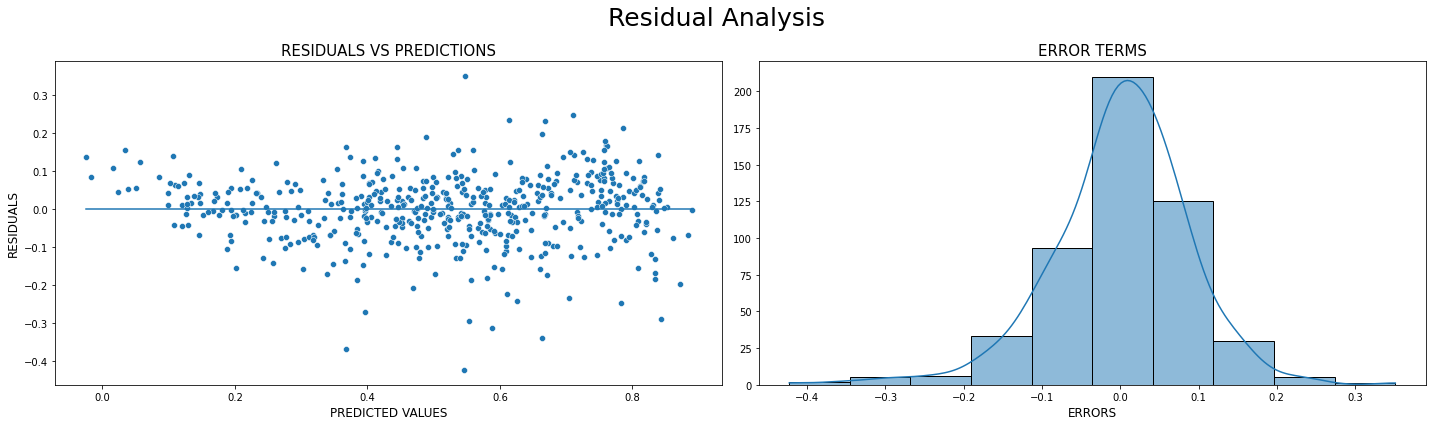

In [79]:
# Visualize residual analysis
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
plt.suptitle('Residual Analysis', fontsize=25)

# Scatter plot of residuals vs predictions
sns.scatterplot(y=residual.values, x= y_train_pred.values, ax=ax[0])
sns.lineplot(y= residual.mean(),x=y_train_pred.values, ax=ax[0])  # Add a horizontal line at the mean of residuals

ax[0].set_title('Residuals vs Predictions'.upper(), fontsize=15)
ax[0].set_ylabel('Residuals'.upper(), fontsize=12)
ax[0].set_xlabel('Predicted Values'.upper(), fontsize=12)

# Histogram of error terms
sns.histplot(residual, kde=True, bins=10, ax=ax[1])

ax[1].set_title('Error Terms'.upper(), fontsize=15)
ax[1].set_ylabel('')
ax[1].set_xlabel('Errors'.upper(), fontsize=12)

plt.tight_layout()
plt.show()


**Observations:**
 - Mean of the residuals is extremely close to 0
 - Normal distribution of errors around mean of 0

#### Independence of Errors

>Assumption: The residuals (errors) are independent.
>
>  - Validation: **Durbin-Watson Test**: This test checks for the presence of autocorrelation in the residuals. A value close to 2 indicates no autocorrelation.

In [80]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson_stat = durbin_watson(residual)
print(durbin_watson_stat)

2.0588505731521383


#### Homoscedasticity

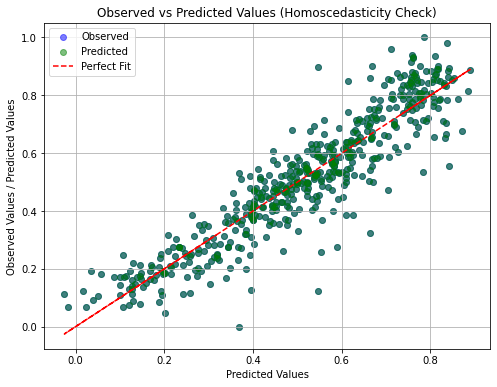

In [81]:
# Assuming y_train and y_train_pred are the actual and predicted target values, respectively
residuals = y_train - y_train_pred

# Create a scatter plot of observed vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train, color='blue', label='Observed', alpha=0.5)
plt.scatter(y_train_pred, y_train_pred + residuals, color='green', label='Predicted', alpha=0.5)
plt.plot(y_train_pred, y_train_pred, color='red', linestyle='--', label='Perfect Fit')  # Add a perfect fit line
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values / Predicted Values')
plt.title('Observed vs Predicted Values (Homoscedasticity Check)')
plt.legend()
plt.grid(True)
plt.show()

**Observation**:
> The plot above shows an almost constant variance of predictions and thus the errors validating the assumptions of homescedasticity.

### Making Predictions

> Applying scalling on test dataset

In [82]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.036530,0.698630,20.815737,24.255828,61.961883,12.600130,4546.981735,0.255708,0.264840,...,0.082192,0.086758,0.127854,0.118721,0.146119,0.164384,0.164384,0.100457,0.027397,0.319635
std,0.500722,0.188034,0.459904,7.689600,8.299641,14.456669,4.984858,1898.633630,0.437258,0.442259,...,0.275286,0.282125,0.334692,0.324202,0.354034,0.371472,0.371472,0.301297,0.163612,0.467403
min,0.000000,0.000000,0.000000,3.957390,4.941955,25.416700,1.500244,441.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,14.093750,17.085500,51.166700,9.021282,3303.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,20.807500,24.873150,60.916700,12.167200,4579.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,27.401653,31.155725,72.192050,15.395629,5869.500000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,34.815847,41.318550,97.250000,27.999836,8395.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [83]:
#creating list of numeric columns which are not yet scalled
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])

In [84]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.036530,0.698630,0.558941,0.532991,0.638508,0.313350,0.520592,0.255708,0.264840,...,0.082192,0.086758,0.127854,0.118721,0.146119,0.164384,0.164384,0.100457,0.027397,0.319635
std,0.500722,0.188034,0.459904,0.233698,0.217888,0.148974,0.159947,0.218435,0.437258,0.442259,...,0.275286,0.282125,0.334692,0.324202,0.354034,0.371472,0.371472,0.301297,0.163612,0.467403
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354650,0.344751,0.527265,0.198517,0.377531,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558691,0.549198,0.627737,0.299459,0.524275,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.759096,0.714132,0.743928,0.403048,0.672745,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dividing data into X_test and y_test 

In [85]:
y_test = df_test.pop('cnt')
X_test = df_test

In [86]:
X_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_Spring,season_Summer,season_Winter,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Rain or Light Snow,weathersit_Misty and Cloudy
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,0,...,0,0,1,0,0,0,0,0,0,1
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,0,...,0,0,0,0,0,0,0,1,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,1,...,1,0,0,0,0,1,0,0,0,1
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,0,...,0,0,0,0,0,0,0,1,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [87]:
X_test.shape

(219, 29)

In [88]:
y_test.shape

(219,)

> **Making actual prediction**

In [89]:
X_test=X_test[X_train_4.columns]  #as our final trained model is model#5 where trained data is X_train_4 and model is lm5
# Adding constant variable to test dataframe
X_test_lm5 = sm.add_constant(X_test)
X_test_lm5.info()


<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, 184 to 72
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   const                                219 non-null    float64
 1   yr                                   219 non-null    int64  
 2   holiday                              219 non-null    int64  
 3   temp                                 219 non-null    float64
 4   windspeed                            219 non-null    float64
 5   season_Spring                        219 non-null    int64  
 6   season_Summer                        219 non-null    int64  
 7   season_Winter                        219 non-null    int64  
 8   mnth_Jul                             219 non-null    int64  
 9   mnth_Sep                             219 non-null    int64  
 10  weekday_Sun                          219 non-null    int64  
 11  weathersit_Light Rain or Light Snow 

In [90]:
# Predict on the test data
y_test_pred = lm5.predict(X_test_lm5)

Text(0, 0.5, 'y_test_pred')

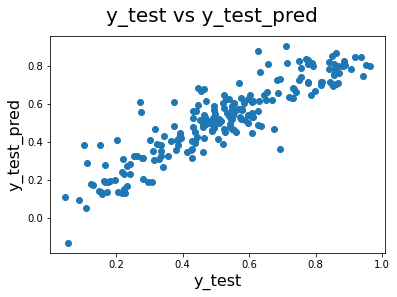

In [91]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=16)                              # X-label
plt.ylabel('y_test_pred', fontsize=16)                          # Y-label

In [92]:
# Calculate R-squared on the training data
r_squared_train = round(r2_score(y_train, y_train_pred),3)
print(f"Training R-squared: {r_squared_train}")

# Calculate Adjusted R-squared on the training data
adjusted_r_squared = round(lm5.rsquared_adj,3)
print(f"Training Adjusted R-squared: {adjusted_r_squared}")

# Calculate R-squared on the test data
r_squared_test = round(r2_score(y_test, y_test_pred),3)
print(f"Test R-squared: {r_squared_test}")

# Calculate Adjusted R-squared on the test data
n_test = X_test.shape[0]
k = X_test.shape[1]
adjusted_r_squared_test = 1 - ((1 - r_squared_test) * (n_test - 1) / (n_test - k - 1))

print(f"Test Adjusted R-squared: {adjusted_r_squared_test:.3f}")

Training R-squared: 0.841
Training Adjusted R-squared: 0.838
Test R-squared: 0.807
Test Adjusted R-squared: 0.796


In [93]:
print(lm5.params.round(3).sort_values(ascending=False))

temp                                   0.491
yr                                     0.233
const                                  0.206
season_Winter                          0.086
mnth_Sep                               0.076
season_Summer                          0.046
weekday_Sun                           -0.048
mnth_Jul                              -0.050
season_Spring                         -0.065
weathersit_Misty and Cloudy           -0.084
holiday                               -0.106
windspeed                             -0.148
weathersit_Light Rain or Light Snow   -0.290
dtype: float64


In [94]:
# Get the model parameters
params = lm5.params.round(3)

# Construct the regression equation
equation = "cnt = "

# Add the intercept
equation += f"{params['const']}"

# Add the rest of the coefficients
for feature, coef in params.items():
    if feature != 'const':
        sign = " + " if coef >= 0 else " - "
        equation += f"{sign}({abs(coef)}* {feature})"

print(equation)


cnt = 0.206 + (0.233* yr) - (0.106* holiday) + (0.491* temp) - (0.148* windspeed) - (0.065* season_Spring) + (0.046* season_Summer) + (0.086* season_Winter) - (0.05* mnth_Jul) + (0.076* mnth_Sep) - (0.048* weekday_Sun) - (0.29* weathersit_Light Rain or Light Snow) - (0.084* weathersit_Misty and Cloudy)


In [95]:
#Defining a function to find top 'n' featured
def nImportantFeatures(series, n):
    series = series.sort_values(key = lambda x: abs(x), ascending = False)
    return series.head(n)

In [96]:
#Identifying all features in decreasing order of importance/relevance
parameter_series = pd.Series(params)
descending_importance = nImportantFeatures(parameter_series, len(parameter_series))
descending_importance

temp                                   0.491
weathersit_Light Rain or Light Snow   -0.290
yr                                     0.233
const                                  0.206
windspeed                             -0.148
holiday                               -0.106
season_Winter                          0.086
weathersit_Misty and Cloudy           -0.084
mnth_Sep                               0.076
season_Spring                         -0.065
mnth_Jul                              -0.050
weekday_Sun                           -0.048
season_Summer                          0.046
dtype: float64